In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))

In [2]:
import json 
from pprint import pprint 
import pandas as pd
import numpy as np
from pathlib import Path
from statistics import variance
import os
import re
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [4]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} JSON files in '{dirpath}'.")

In [5]:
data_path = Path("ALGORITM/")
walk_through_dir(data_path)
files = os.listdir('ALGORITM/')

There are 0 directories and 628 JSON files in 'ALGORITM'.


In [6]:
# Get all file paths - все файлы в папке ALGORITM
file_path_list = list(data_path.glob("*.json"))

i = 0
file_id=list()
print(type(file_id))
for file in file_path_list: 
   
    #print(f"{i+1} file path: {file_path_list[i]}")
    fp = str(file_path_list[i])
    file_id.append(fp[-10:-5])
    i+=1

<class 'list'>


Разобьем задачу на несколько шагов.

In [7]:
def calc_var(data):
    if len(data)>1:
        return variance(data)
    else:
        return 0

In [9]:
#k = 0
load_data = pd.DataFrame()
ld = pd.DataFrame()
print(len(files))
for f in trange(len(files)): 
    df = pd.read_json('ALGORITM/'+ files[f])
    file_id = files[f][-10:-5]
    length = len(df[df.index =='boxes'].values[0][1])
    print(length)
    boxes = pd.DataFrame()
    all_cargoes_space_result = pd.DataFrame()
 
    data0 = df[df.index =='cargo_space'].values[0][1]
    atom_df = {
    'loading_size': data0['loading_size'],
    'calculation_info': data0['calculation_info']
     }

    temp = pd.json_normalize(atom_df)
    all_cargoes_space_result = pd.concat([all_cargoes_space_result, temp], axis=0).reset_index(drop=True)
    
    #Начнем заполнять итоговую табличку с параметрами
    density_percent=all_cargoes_space_result['calculation_info.density_percent'][0] # Плотность укладки
    filling_space_percent=all_cargoes_space_result['calculation_info.filling_space_percent'][0]    # target метрика
    cargo_width=all_cargoes_space_result['loading_size.width'][0]     # размер контейнера
    cargo_height=all_cargoes_space_result['loading_size.height'][0]   # размер контейнера
    cargo_length=all_cargoes_space_result['loading_size.length'][0]   # размер контейнера
    cargo_volume=cargo_width*cargo_height*cargo_length #объем контейнера
    cargo_area=cargo_width*cargo_length #площадь контейнера
    
    
    
    


    # вывод таблиц с размерами и свойствами коробок, а их дофига...
    for i in trange(length):
        data = df[df.index =='boxes'].values[0][1][i]
        #проведем предварительные вычисления                                 
        b_width=data['size']['width'] #ширина коробки
        b_height=data['size']['height'] #высота коробки
        b_length=data['size']['length'] #длина коробки
        box_volume=b_width*b_height*b_length #объем коробки
        #упорядочим размеры. При получении новой коробки мы вообще не знаем как она будет лежать поэтому размеры псевдо
        #Эти параметры нужны нам для описания неоднородости коробок по их линейным параметрам 
        pseudo_size=sorted([b_width,b_height,b_length]) 
        pseudo_height=pseudo_size[2] #псевдо высота (самая большая сторона)
        pseudo_length=pseudo_size[0] #псевдо длина (самая маленькая)
        pseudo_area_min=pseudo_size[0]*pseudo_size[1] #площадь минимальной стороны
        pseudo_area_max=pseudo_size[1]*pseudo_size[2] #площадь максимальной стороны
        real_area=b_width*b_length # настоящая площадь для непереворачиваемых коробок
        real_height=b_height # настоящая высота для непереворачиваемых коробок
        # Формируем таблицу с параметрами коробок
        atom_df = pd.DataFrame({
                   'box_volume': box_volume, #объем коробки
                   'box_volume_norm_vs_cargo': box_volume/cargo_volume, #доля коробки в контейнере (потом средневзвешенное посчитаем)
                    'oversize':pseudo_height//min(cargo_width,cargo_height,cargo_length), #признак если самая большая сторона коробки больше самой маленькой стороны контейнера
                    'flatness': pseudo_area_max/pseudo_length, #"плоскость коробки"
                    'lengthness':pseudo_area_min/pseudo_height, #вытянутость коробки
                    'turnover_area':real_area*(not data['turnover']), #площадь непереворачиваемой коробки
                    'turnover_height':real_height*(not data['turnover']), #высота непереворачиваемой коробки
                   'stacking': data['stacking'], #признак складирования коробки
                   'turnover': data['turnover']}, index=[0])  #признак переворачиваемости
#         atom_df.stacking = atom_df.stacking.replace({True: 1, False: 0})
#         atom_df.turnover = atom_df.turnover.replace({True: 1, False: 0})
        boxes = pd.concat([boxes,atom_df], axis=0).reset_index(drop=True)
    
    boxes['box_volume_norm_vs_boxes']=boxes['box_volume']/boxes['box_volume'].sum() #доля коробки во всем объеме коробок (потом средневзвешенное посчитаем)
     
        
    load_data = [{'density_percent':density_percent,
         'filling_space_percent':filling_space_percent,    # target метрика
         'cargo_width':cargo_width,     # размер контейнера
         'cargo_height':cargo_height,   # размер контейнера
         'cargo_length':cargo_length,   # размер контейнера
         'cargo_area':cargo_area,       #площадь контейнера
         'cargo_volume':cargo_volume,   #объем контейнера      
         'boxes_volume':boxes['box_volume'].sum(),        # суммарный объем коробок в контнйнере 
# Вычислим статистические параметры распределения объемов коробок, среднее, медиана, дисперсию, и отношение медианы к среднему.
#Таким образом хотим уловить однородность
         'boxes_volume_mean':  boxes['box_volume'].mean(),   
         'boxes_volume_median':  boxes['box_volume'].median(),
         'boxes_volume_var': calc_var(boxes['box_volume']),       
         'boxes_volume_lag': boxes['box_volume'].mean()/boxes['box_volume'].median(),
# Вычислим средневзвешенные средние объемов коробок  по общему объему и по объему контейнера          
         'boxes_volume_norm_vs_boxes_mean': (boxes['box_volume']*boxes['box_volume_norm_vs_boxes']).sum()/boxes['box_volume_norm_vs_boxes'].sum(),   
         'boxes_volume_norm_vs_cargo_mean': (boxes['box_volume']*boxes['box_volume_norm_vs_cargo']).sum()/boxes['box_volume_norm_vs_cargo'].sum(),     
# Вычислим всякие ништяки для особенных коробок, в основном эта их доля в наборе                  
         'stacking_volume_cargo_perc':(boxes['box_volume']*(1- boxes['stacking'])).sum()/cargo_volume, #процент объема нештабилируемых в контейнере
         'stacking_volume_boxes_perc':(boxes['box_volume']*(1- boxes['stacking'])).sum()/boxes['box_volume'].sum(), #процент объема нештабилируемых в наборе
         'oversize_volume_boxes_perc':(boxes['box_volume']*(boxes['oversize'])).sum()/boxes['box_volume'].sum(), #процент слишком больших в наборе   
         'turnover_volume_cargo_perc':(boxes['box_volume']*(1- boxes['turnover'])).sum()/cargo_volume, #процент объема непереворачиваемых в контейнере
         'turnover_volume_boxes_perc':(boxes['box_volume']*(1- boxes['turnover'])).sum()/boxes['box_volume'].sum(), #процент объема непереворачиваемых в наборе                 
         'turnover_area':boxes['turnover_area'].sum()/cargo_area, #Для непереворачиваемых можем долю площади в контейнере посчитать
         'turnover_heiht':boxes['turnover_height'].max()/cargo_height, #Для непереворачиваемых максимальныя высота к высоте контейнера
# Вычислим статистические параметры распределения для линейных параметров коробок, среднее, медиана, дисперсию, и отношение медианы к среднему.
#Таким образом хотим уловить однородность
#"Плоскость"
         'flatness_max':  boxes['flatness'].max(), 
         'flatness_mean':  boxes['flatness'].mean(),   
         'flatness_median':  boxes['flatness'].median(),
         'flatness_var': calc_var(boxes['flatness']),       
         'flatness_lag': boxes['flatness'].mean()/boxes['flatness'].median(),
#Вытянутость                  
         'lengthness_min':  boxes['lengthness'].min(), 
         'lengthness_mean':  boxes['lengthness'].mean(),   
         'lengthness_median':  boxes['lengthness'].median(),
         'lengthness_var': calc_var(boxes['lengthness']),       
         'lengthness_lag': boxes['lengthness'].mean()/boxes['lengthness'].median(),
                  

         'mean_stacking':boxes['stacking'].mean(),   # усредненная штабелируемость 
         'mean_turnover':boxes['turnover'].mean(),   # усредненная кантуемость 
         'boxes_qty':length}]        # количество коробок в контейнере


        # создание таблицы свойств карго со всех файлов  


    ld = pd.concat((ld, pd.DataFrame(load_data)))


628


  0%|          | 0/628 [00:00<?, ?it/s]

270


  0%|          | 0/270 [00:00<?, ?it/s]

33


  0%|          | 0/33 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

33


  0%|          | 0/33 [00:00<?, ?it/s]

33


  0%|          | 0/33 [00:00<?, ?it/s]

966


  0%|          | 0/966 [00:00<?, ?it/s]

7


  0%|          | 0/7 [00:00<?, ?it/s]

54


  0%|          | 0/54 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

7


  0%|          | 0/7 [00:00<?, ?it/s]

40


  0%|          | 0/40 [00:00<?, ?it/s]

53


  0%|          | 0/53 [00:00<?, ?it/s]

66


  0%|          | 0/66 [00:00<?, ?it/s]

66


  0%|          | 0/66 [00:00<?, ?it/s]

2000


  0%|          | 0/2000 [00:00<?, ?it/s]

2000


  0%|          | 0/2000 [00:00<?, ?it/s]

59


  0%|          | 0/59 [00:00<?, ?it/s]

49


  0%|          | 0/49 [00:00<?, ?it/s]

49


  0%|          | 0/49 [00:00<?, ?it/s]

53


  0%|          | 0/53 [00:00<?, ?it/s]

51


  0%|          | 0/51 [00:00<?, ?it/s]

51


  0%|          | 0/51 [00:00<?, ?it/s]

48


  0%|          | 0/48 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

26


  0%|          | 0/26 [00:00<?, ?it/s]

26


  0%|          | 0/26 [00:00<?, ?it/s]

66


  0%|          | 0/66 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

32


  0%|          | 0/32 [00:00<?, ?it/s]

32


  0%|          | 0/32 [00:00<?, ?it/s]

12


  0%|          | 0/12 [00:00<?, ?it/s]

13


  0%|          | 0/13 [00:00<?, ?it/s]

15


  0%|          | 0/15 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

4


  0%|          | 0/4 [00:00<?, ?it/s]

8


  0%|          | 0/8 [00:00<?, ?it/s]

8


  0%|          | 0/8 [00:00<?, ?it/s]

21


  0%|          | 0/21 [00:00<?, ?it/s]

21


  0%|          | 0/21 [00:00<?, ?it/s]

50


  0%|          | 0/50 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

460


  0%|          | 0/460 [00:00<?, ?it/s]

24


  0%|          | 0/24 [00:00<?, ?it/s]

25


  0%|          | 0/25 [00:00<?, ?it/s]

25


  0%|          | 0/25 [00:00<?, ?it/s]

25


  0%|          | 0/25 [00:00<?, ?it/s]

9


  0%|          | 0/9 [00:00<?, ?it/s]

35


  0%|          | 0/35 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

34


  0%|          | 0/34 [00:00<?, ?it/s]

34


  0%|          | 0/34 [00:00<?, ?it/s]

35


  0%|          | 0/35 [00:00<?, ?it/s]

355


  0%|          | 0/355 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

40


  0%|          | 0/40 [00:00<?, ?it/s]

60


  0%|          | 0/60 [00:00<?, ?it/s]

40


  0%|          | 0/40 [00:00<?, ?it/s]

100


  0%|          | 0/100 [00:00<?, ?it/s]

105


  0%|          | 0/105 [00:00<?, ?it/s]

8


  0%|          | 0/8 [00:00<?, ?it/s]

8


  0%|          | 0/8 [00:00<?, ?it/s]

8


  0%|          | 0/8 [00:00<?, ?it/s]

300


  0%|          | 0/300 [00:00<?, ?it/s]

1200


  0%|          | 0/1200 [00:00<?, ?it/s]

1449


  0%|          | 0/1449 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

25


  0%|          | 0/25 [00:00<?, ?it/s]

25


  0%|          | 0/25 [00:00<?, ?it/s]

973


  0%|          | 0/973 [00:00<?, ?it/s]

270


  0%|          | 0/270 [00:00<?, ?it/s]

247


  0%|          | 0/247 [00:00<?, ?it/s]

34


  0%|          | 0/34 [00:00<?, ?it/s]

33


  0%|          | 0/33 [00:00<?, ?it/s]

35


  0%|          | 0/35 [00:00<?, ?it/s]

44


  0%|          | 0/44 [00:00<?, ?it/s]

47


  0%|          | 0/47 [00:00<?, ?it/s]

15


  0%|          | 0/15 [00:00<?, ?it/s]

35


  0%|          | 0/35 [00:00<?, ?it/s]

26


  0%|          | 0/26 [00:00<?, ?it/s]

26


  0%|          | 0/26 [00:00<?, ?it/s]

26


  0%|          | 0/26 [00:00<?, ?it/s]

27


  0%|          | 0/27 [00:00<?, ?it/s]

27


  0%|          | 0/27 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

4


  0%|          | 0/4 [00:00<?, ?it/s]

36


  0%|          | 0/36 [00:00<?, ?it/s]

8


  0%|          | 0/8 [00:00<?, ?it/s]

8


  0%|          | 0/8 [00:00<?, ?it/s]

32


  0%|          | 0/32 [00:00<?, ?it/s]

175


  0%|          | 0/175 [00:00<?, ?it/s]

537


  0%|          | 0/537 [00:00<?, ?it/s]

637


  0%|          | 0/637 [00:00<?, ?it/s]

554


  0%|          | 0/554 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

32


  0%|          | 0/32 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

35


  0%|          | 0/35 [00:00<?, ?it/s]

32


  0%|          | 0/32 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

88


  0%|          | 0/88 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

26


  0%|          | 0/26 [00:00<?, ?it/s]

92


  0%|          | 0/92 [00:00<?, ?it/s]

92


  0%|          | 0/92 [00:00<?, ?it/s]

86


  0%|          | 0/86 [00:00<?, ?it/s]

85


  0%|          | 0/85 [00:00<?, ?it/s]

88


  0%|          | 0/88 [00:00<?, ?it/s]

78


  0%|          | 0/78 [00:00<?, ?it/s]

172


  0%|          | 0/172 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

24


  0%|          | 0/24 [00:00<?, ?it/s]

39


  0%|          | 0/39 [00:00<?, ?it/s]

240


  0%|          | 0/240 [00:00<?, ?it/s]

240


  0%|          | 0/240 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

8


  0%|          | 0/8 [00:00<?, ?it/s]

9


  0%|          | 0/9 [00:00<?, ?it/s]

9


  0%|          | 0/9 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

15


  0%|          | 0/15 [00:00<?, ?it/s]

9


  0%|          | 0/9 [00:00<?, ?it/s]

73


  0%|          | 0/73 [00:00<?, ?it/s]

73


  0%|          | 0/73 [00:00<?, ?it/s]

73


  0%|          | 0/73 [00:00<?, ?it/s]

73


  0%|          | 0/73 [00:00<?, ?it/s]

82


  0%|          | 0/82 [00:00<?, ?it/s]

82


  0%|          | 0/82 [00:00<?, ?it/s]

82


  0%|          | 0/82 [00:00<?, ?it/s]

82


  0%|          | 0/82 [00:00<?, ?it/s]

82


  0%|          | 0/82 [00:00<?, ?it/s]

100


  0%|          | 0/100 [00:00<?, ?it/s]

100


  0%|          | 0/100 [00:00<?, ?it/s]

3


  0%|          | 0/3 [00:00<?, ?it/s]

59


  0%|          | 0/59 [00:00<?, ?it/s]

15


  0%|          | 0/15 [00:00<?, ?it/s]

59


  0%|          | 0/59 [00:00<?, ?it/s]

15


  0%|          | 0/15 [00:00<?, ?it/s]

240


  0%|          | 0/240 [00:00<?, ?it/s]

73


  0%|          | 0/73 [00:00<?, ?it/s]

73


  0%|          | 0/73 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

4


  0%|          | 0/4 [00:00<?, ?it/s]

4


  0%|          | 0/4 [00:00<?, ?it/s]

66


  0%|          | 0/66 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

19


  0%|          | 0/19 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

19


  0%|          | 0/19 [00:00<?, ?it/s]

35


  0%|          | 0/35 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

88


  0%|          | 0/88 [00:00<?, ?it/s]

73


  0%|          | 0/73 [00:00<?, ?it/s]

50


  0%|          | 0/50 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

82


  0%|          | 0/82 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

13


  0%|          | 0/13 [00:00<?, ?it/s]

226


  0%|          | 0/226 [00:00<?, ?it/s]

8


  0%|          | 0/8 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

23


  0%|          | 0/23 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

8


  0%|          | 0/8 [00:00<?, ?it/s]

6


  0%|          | 0/6 [00:00<?, ?it/s]

6


  0%|          | 0/6 [00:00<?, ?it/s]

96


  0%|          | 0/96 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

35


  0%|          | 0/35 [00:00<?, ?it/s]

35


  0%|          | 0/35 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

3


  0%|          | 0/3 [00:00<?, ?it/s]

3


  0%|          | 0/3 [00:00<?, ?it/s]

5


  0%|          | 0/5 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

90


  0%|          | 0/90 [00:00<?, ?it/s]

15


  0%|          | 0/15 [00:00<?, ?it/s]

12


  0%|          | 0/12 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

19


  0%|          | 0/19 [00:00<?, ?it/s]

19


  0%|          | 0/19 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

12


  0%|          | 0/12 [00:00<?, ?it/s]

19


  0%|          | 0/19 [00:00<?, ?it/s]

59


  0%|          | 0/59 [00:00<?, ?it/s]

59


  0%|          | 0/59 [00:00<?, ?it/s]

4


  0%|          | 0/4 [00:00<?, ?it/s]

5


  0%|          | 0/5 [00:00<?, ?it/s]

7


  0%|          | 0/7 [00:00<?, ?it/s]

7


  0%|          | 0/7 [00:00<?, ?it/s]

19


  0%|          | 0/19 [00:00<?, ?it/s]

12


  0%|          | 0/12 [00:00<?, ?it/s]

12


  0%|          | 0/12 [00:00<?, ?it/s]

23


  0%|          | 0/23 [00:00<?, ?it/s]

23


  0%|          | 0/23 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

27


  0%|          | 0/27 [00:00<?, ?it/s]

45


  0%|          | 0/45 [00:00<?, ?it/s]

115


  0%|          | 0/115 [00:00<?, ?it/s]

12


  0%|          | 0/12 [00:00<?, ?it/s]

48


  0%|          | 0/48 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

15


  0%|          | 0/15 [00:00<?, ?it/s]

15


  0%|          | 0/15 [00:00<?, ?it/s]

8


  0%|          | 0/8 [00:00<?, ?it/s]

355


  0%|          | 0/355 [00:00<?, ?it/s]

216


  0%|          | 0/216 [00:00<?, ?it/s]

355


  0%|          | 0/355 [00:00<?, ?it/s]

494


  0%|          | 0/494 [00:00<?, ?it/s]

1344


  0%|          | 0/1344 [00:00<?, ?it/s]

2220


  0%|          | 0/2220 [00:00<?, ?it/s]

12


  0%|          | 0/12 [00:00<?, ?it/s]

24


  0%|          | 0/24 [00:00<?, ?it/s]

117


  0%|          | 0/117 [00:00<?, ?it/s]

136


  0%|          | 0/136 [00:00<?, ?it/s]

168


  0%|          | 0/168 [00:00<?, ?it/s]

57


  0%|          | 0/57 [00:00<?, ?it/s]

168


  0%|          | 0/168 [00:00<?, ?it/s]

168


  0%|          | 0/168 [00:00<?, ?it/s]

168


  0%|          | 0/168 [00:00<?, ?it/s]

30


  0%|          | 0/30 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

315


  0%|          | 0/315 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

25


  0%|          | 0/25 [00:00<?, ?it/s]

592


  0%|          | 0/592 [00:00<?, ?it/s]

5


  0%|          | 0/5 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

53


  0%|          | 0/53 [00:00<?, ?it/s]

26


  0%|          | 0/26 [00:00<?, ?it/s]

583


  0%|          | 0/583 [00:00<?, ?it/s]

583


  0%|          | 0/583 [00:00<?, ?it/s]

582


  0%|          | 0/582 [00:00<?, ?it/s]

582


  0%|          | 0/582 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

621


  0%|          | 0/621 [00:00<?, ?it/s]

622


  0%|          | 0/622 [00:00<?, ?it/s]

621


  0%|          | 0/621 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

8


  0%|          | 0/8 [00:00<?, ?it/s]

32


  0%|          | 0/32 [00:00<?, ?it/s]

24


  0%|          | 0/24 [00:00<?, ?it/s]

32


  0%|          | 0/32 [00:00<?, ?it/s]

621


  0%|          | 0/621 [00:00<?, ?it/s]

622


  0%|          | 0/622 [00:00<?, ?it/s]

621


  0%|          | 0/621 [00:00<?, ?it/s]

7


  0%|          | 0/7 [00:00<?, ?it/s]

626


  0%|          | 0/626 [00:00<?, ?it/s]

4


  0%|          | 0/4 [00:00<?, ?it/s]

4


  0%|          | 0/4 [00:00<?, ?it/s]

5


  0%|          | 0/5 [00:00<?, ?it/s]

81


  0%|          | 0/81 [00:00<?, ?it/s]

153


  0%|          | 0/153 [00:00<?, ?it/s]

30


  0%|          | 0/30 [00:00<?, ?it/s]

30


  0%|          | 0/30 [00:00<?, ?it/s]

30


  0%|          | 0/30 [00:00<?, ?it/s]

13


  0%|          | 0/13 [00:00<?, ?it/s]

8


  0%|          | 0/8 [00:00<?, ?it/s]

15


  0%|          | 0/15 [00:00<?, ?it/s]

11


  0%|          | 0/11 [00:00<?, ?it/s]

12


  0%|          | 0/12 [00:00<?, ?it/s]

11


  0%|          | 0/11 [00:00<?, ?it/s]

312


  0%|          | 0/312 [00:00<?, ?it/s]

508


  0%|          | 0/508 [00:00<?, ?it/s]

362


  0%|          | 0/362 [00:00<?, ?it/s]

24


  0%|          | 0/24 [00:00<?, ?it/s]

411


  0%|          | 0/411 [00:00<?, ?it/s]

508


  0%|          | 0/508 [00:00<?, ?it/s]

342


  0%|          | 0/342 [00:00<?, ?it/s]

90


  0%|          | 0/90 [00:00<?, ?it/s]

60


  0%|          | 0/60 [00:00<?, ?it/s]

72


  0%|          | 0/72 [00:00<?, ?it/s]

40


  0%|          | 0/40 [00:00<?, ?it/s]

207


  0%|          | 0/207 [00:00<?, ?it/s]

214


  0%|          | 0/214 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

54


  0%|          | 0/54 [00:00<?, ?it/s]

50


  0%|          | 0/50 [00:00<?, ?it/s]

100


  0%|          | 0/100 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

60


  0%|          | 0/60 [00:00<?, ?it/s]

33


  0%|          | 0/33 [00:00<?, ?it/s]

33


  0%|          | 0/33 [00:00<?, ?it/s]

21


  0%|          | 0/21 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

26


  0%|          | 0/26 [00:00<?, ?it/s]

34


  0%|          | 0/34 [00:00<?, ?it/s]

33


  0%|          | 0/33 [00:00<?, ?it/s]

33


  0%|          | 0/33 [00:00<?, ?it/s]

1800


  0%|          | 0/1800 [00:00<?, ?it/s]

4


  0%|          | 0/4 [00:00<?, ?it/s]

31


  0%|          | 0/31 [00:00<?, ?it/s]

3


  0%|          | 0/3 [00:00<?, ?it/s]

5


  0%|          | 0/5 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

19


  0%|          | 0/19 [00:00<?, ?it/s]

19


  0%|          | 0/19 [00:00<?, ?it/s]

27


  0%|          | 0/27 [00:00<?, ?it/s]

27


  0%|          | 0/27 [00:00<?, ?it/s]

5


  0%|          | 0/5 [00:00<?, ?it/s]

5


  0%|          | 0/5 [00:00<?, ?it/s]

33


  0%|          | 0/33 [00:00<?, ?it/s]

7


  0%|          | 0/7 [00:00<?, ?it/s]

13


  0%|          | 0/13 [00:00<?, ?it/s]

12


  0%|          | 0/12 [00:00<?, ?it/s]

6


  0%|          | 0/6 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

183


  0%|          | 0/183 [00:00<?, ?it/s]

3


  0%|          | 0/3 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

12


  0%|          | 0/12 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

15


  0%|          | 0/15 [00:00<?, ?it/s]

510


  0%|          | 0/510 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

12


  0%|          | 0/12 [00:00<?, ?it/s]

15


  0%|          | 0/15 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

13


  0%|          | 0/13 [00:00<?, ?it/s]

13


  0%|          | 0/13 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

32


  0%|          | 0/32 [00:00<?, ?it/s]

32


  0%|          | 0/32 [00:00<?, ?it/s]

32


  0%|          | 0/32 [00:00<?, ?it/s]

48


  0%|          | 0/48 [00:00<?, ?it/s]

9


  0%|          | 0/9 [00:00<?, ?it/s]

11


  0%|          | 0/11 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

8


  0%|          | 0/8 [00:00<?, ?it/s]

211


  0%|          | 0/211 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

24


  0%|          | 0/24 [00:00<?, ?it/s]

42


  0%|          | 0/42 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

31


  0%|          | 0/31 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

12


  0%|          | 0/12 [00:00<?, ?it/s]

9


  0%|          | 0/9 [00:00<?, ?it/s]

12


  0%|          | 0/12 [00:00<?, ?it/s]

35


  0%|          | 0/35 [00:00<?, ?it/s]

12


  0%|          | 0/12 [00:00<?, ?it/s]

115


  0%|          | 0/115 [00:00<?, ?it/s]

180


  0%|          | 0/180 [00:00<?, ?it/s]

1087


  0%|          | 0/1087 [00:00<?, ?it/s]

1087


  0%|          | 0/1087 [00:00<?, ?it/s]

1087


  0%|          | 0/1087 [00:00<?, ?it/s]

100


  0%|          | 0/100 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

37


  0%|          | 0/37 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

9


  0%|          | 0/9 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

15


  0%|          | 0/15 [00:00<?, ?it/s]

27


  0%|          | 0/27 [00:00<?, ?it/s]

27


  0%|          | 0/27 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

15


  0%|          | 0/15 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

36


  0%|          | 0/36 [00:00<?, ?it/s]

11


  0%|          | 0/11 [00:00<?, ?it/s]

11


  0%|          | 0/11 [00:00<?, ?it/s]

36


  0%|          | 0/36 [00:00<?, ?it/s]

13


  0%|          | 0/13 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

68


  0%|          | 0/68 [00:00<?, ?it/s]

96


  0%|          | 0/96 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

5


  0%|          | 0/5 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

3


  0%|          | 0/3 [00:00<?, ?it/s]

4


  0%|          | 0/4 [00:00<?, ?it/s]

156


  0%|          | 0/156 [00:00<?, ?it/s]

112


  0%|          | 0/112 [00:00<?, ?it/s]

116


  0%|          | 0/116 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

19


  0%|          | 0/19 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

7


  0%|          | 0/7 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

924


  0%|          | 0/924 [00:00<?, ?it/s]

924


  0%|          | 0/924 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

200


  0%|          | 0/200 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

86


  0%|          | 0/86 [00:00<?, ?it/s]

72


  0%|          | 0/72 [00:00<?, ?it/s]

73


  0%|          | 0/73 [00:00<?, ?it/s]

72


  0%|          | 0/72 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

24


  0%|          | 0/24 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

25


  0%|          | 0/25 [00:00<?, ?it/s]

355


  0%|          | 0/355 [00:00<?, ?it/s]

100


  0%|          | 0/100 [00:00<?, ?it/s]

200


  0%|          | 0/200 [00:00<?, ?it/s]

512


  0%|          | 0/512 [00:00<?, ?it/s]

512


  0%|          | 0/512 [00:00<?, ?it/s]

6


  0%|          | 0/6 [00:00<?, ?it/s]

75


  0%|          | 0/75 [00:00<?, ?it/s]

108


  0%|          | 0/108 [00:00<?, ?it/s]

108


  0%|          | 0/108 [00:00<?, ?it/s]

129


  0%|          | 0/129 [00:00<?, ?it/s]

30


  0%|          | 0/30 [00:00<?, ?it/s]

2849


  0%|          | 0/2849 [00:00<?, ?it/s]

30


  0%|          | 0/30 [00:00<?, ?it/s]

2656


  0%|          | 0/2656 [00:00<?, ?it/s]

17


  0%|          | 0/17 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

7


  0%|          | 0/7 [00:00<?, ?it/s]

32


  0%|          | 0/32 [00:00<?, ?it/s]

60


  0%|          | 0/60 [00:00<?, ?it/s]

36


  0%|          | 0/36 [00:00<?, ?it/s]

26


  0%|          | 0/26 [00:00<?, ?it/s]

52


  0%|          | 0/52 [00:00<?, ?it/s]

52


  0%|          | 0/52 [00:00<?, ?it/s]

25


  0%|          | 0/25 [00:00<?, ?it/s]

4


  0%|          | 0/4 [00:00<?, ?it/s]

53


  0%|          | 0/53 [00:00<?, ?it/s]

241


  0%|          | 0/241 [00:00<?, ?it/s]

60


  0%|          | 0/60 [00:00<?, ?it/s]

120


  0%|          | 0/120 [00:00<?, ?it/s]

56


  0%|          | 0/56 [00:00<?, ?it/s]

495


  0%|          | 0/495 [00:00<?, ?it/s]

147


  0%|          | 0/147 [00:00<?, ?it/s]

890


  0%|          | 0/890 [00:00<?, ?it/s]

4


  0%|          | 0/4 [00:00<?, ?it/s]

6


  0%|          | 0/6 [00:00<?, ?it/s]

24


  0%|          | 0/24 [00:00<?, ?it/s]

1800


  0%|          | 0/1800 [00:00<?, ?it/s]

12


  0%|          | 0/12 [00:00<?, ?it/s]

230


  0%|          | 0/230 [00:00<?, ?it/s]

242


  0%|          | 0/242 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

60


  0%|          | 0/60 [00:00<?, ?it/s]

103


  0%|          | 0/103 [00:00<?, ?it/s]

122


  0%|          | 0/122 [00:00<?, ?it/s]

122


  0%|          | 0/122 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

56


  0%|          | 0/56 [00:00<?, ?it/s]

84


  0%|          | 0/84 [00:00<?, ?it/s]

9


  0%|          | 0/9 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

588


  0%|          | 0/588 [00:00<?, ?it/s]

726


  0%|          | 0/726 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

6


  0%|          | 0/6 [00:00<?, ?it/s]

6


  0%|          | 0/6 [00:00<?, ?it/s]

27


  0%|          | 0/27 [00:00<?, ?it/s]

27


  0%|          | 0/27 [00:00<?, ?it/s]

1293


  0%|          | 0/1293 [00:00<?, ?it/s]

140


  0%|          | 0/140 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

24


  0%|          | 0/24 [00:00<?, ?it/s]

4


  0%|          | 0/4 [00:00<?, ?it/s]

6


  0%|          | 0/6 [00:00<?, ?it/s]

40


  0%|          | 0/40 [00:00<?, ?it/s]

40


  0%|          | 0/40 [00:00<?, ?it/s]

24


  0%|          | 0/24 [00:00<?, ?it/s]

32


  0%|          | 0/32 [00:00<?, ?it/s]

32


  0%|          | 0/32 [00:00<?, ?it/s]

34


  0%|          | 0/34 [00:00<?, ?it/s]

18


  0%|          | 0/18 [00:00<?, ?it/s]

47


  0%|          | 0/47 [00:00<?, ?it/s]

60


  0%|          | 0/60 [00:00<?, ?it/s]

50


  0%|          | 0/50 [00:00<?, ?it/s]

56


  0%|          | 0/56 [00:00<?, ?it/s]

55


  0%|          | 0/55 [00:00<?, ?it/s]

57


  0%|          | 0/57 [00:00<?, ?it/s]

85


  0%|          | 0/85 [00:00<?, ?it/s]

85


  0%|          | 0/85 [00:00<?, ?it/s]

80


  0%|          | 0/80 [00:00<?, ?it/s]

85


  0%|          | 0/85 [00:00<?, ?it/s]

85


  0%|          | 0/85 [00:00<?, ?it/s]

85


  0%|          | 0/85 [00:00<?, ?it/s]

80


  0%|          | 0/80 [00:00<?, ?it/s]

57


  0%|          | 0/57 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

903


  0%|          | 0/903 [00:00<?, ?it/s]

998


  0%|          | 0/998 [00:00<?, ?it/s]

777


  0%|          | 0/777 [00:00<?, ?it/s]

6


  0%|          | 0/6 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

58


  0%|          | 0/58 [00:00<?, ?it/s]

30


  0%|          | 0/30 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

30


  0%|          | 0/30 [00:00<?, ?it/s]

58


  0%|          | 0/58 [00:00<?, ?it/s]

58


  0%|          | 0/58 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

14


  0%|          | 0/14 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

3


  0%|          | 0/3 [00:00<?, ?it/s]

1000


  0%|          | 0/1000 [00:00<?, ?it/s]

26


  0%|          | 0/26 [00:00<?, ?it/s]

64


  0%|          | 0/64 [00:00<?, ?it/s]

37


  0%|          | 0/37 [00:00<?, ?it/s]

42


  0%|          | 0/42 [00:00<?, ?it/s]

16


  0%|          | 0/16 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

101


  0%|          | 0/101 [00:00<?, ?it/s]

50


  0%|          | 0/50 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

355


  0%|          | 0/355 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

35


  0%|          | 0/35 [00:00<?, ?it/s]

57


  0%|          | 0/57 [00:00<?, ?it/s]

44


  0%|          | 0/44 [00:00<?, ?it/s]

100


  0%|          | 0/100 [00:00<?, ?it/s]

57


  0%|          | 0/57 [00:00<?, ?it/s]

120


  0%|          | 0/120 [00:00<?, ?it/s]

9


  0%|          | 0/9 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

141


  0%|          | 0/141 [00:00<?, ?it/s]

143


  0%|          | 0/143 [00:00<?, ?it/s]

98


  0%|          | 0/98 [00:00<?, ?it/s]

143


  0%|          | 0/143 [00:00<?, ?it/s]

143


  0%|          | 0/143 [00:00<?, ?it/s]

143


  0%|          | 0/143 [00:00<?, ?it/s]

355


  0%|          | 0/355 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

606


  0%|          | 0/606 [00:00<?, ?it/s]

40


  0%|          | 0/40 [00:00<?, ?it/s]

25


  0%|          | 0/25 [00:00<?, ?it/s]

200


  0%|          | 0/200 [00:00<?, ?it/s]

216


  0%|          | 0/216 [00:00<?, ?it/s]

216


  0%|          | 0/216 [00:00<?, ?it/s]

8


  0%|          | 0/8 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

25


  0%|          | 0/25 [00:00<?, ?it/s]

26


  0%|          | 0/26 [00:00<?, ?it/s]

25


  0%|          | 0/25 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

22


  0%|          | 0/22 [00:00<?, ?it/s]

20


  0%|          | 0/20 [00:00<?, ?it/s]

6


  0%|          | 0/6 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

29


  0%|          | 0/29 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

31


  0%|          | 0/31 [00:00<?, ?it/s]

28


  0%|          | 0/28 [00:00<?, ?it/s]

31


  0%|          | 0/31 [00:00<?, ?it/s]

1


  0%|          | 0/1 [00:00<?, ?it/s]

2


  0%|          | 0/2 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
boxes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   box_volume                10 non-null     float64
 1   box_volume_norm_vs_cargo  10 non-null     float64
 2   oversize                  10 non-null     float64
 3   flatness                  10 non-null     float64
 4   lengthness                10 non-null     float64
 5   turnover_area             10 non-null     float64
 6   turnover_height           10 non-null     float64
 7   stacking                  10 non-null     bool   
 8   turnover                  10 non-null     bool   
 9   box_volume_norm_vs_boxes  10 non-null     float64
dtypes: bool(2), float64(8)
memory usage: 788.0 bytes


In [11]:
 # вывод таблицы свойств карго со всех файлов 
ld.reset_index(drop=True).head()

,density_percent,filling_space_percent,cargo_width,cargo_height,cargo_length,cargo_area,cargo_volume,boxes_volume,boxes_volume_mean,boxes_volume_median,...,flatness_var,flatness_lag,lengthness_min,lengthness_mean,lengthness_median,lengthness_var,lengthness_lag,mean_stacking,mean_turnover,boxes_qty
0,81.76416,81.72327,800.0,2000.0,1200.0,960000.0,1.920000e+09,1.569087e+09,5.811433e+06,5.448080e+06,...,7141.745368,0.954155,36.642857,103.575667,102.889831,1757.934697,1.006666,1.0,1.0,270
1,82.50000,51.56250,800.0,2000.0,1200.0,960000.0,1.920000e+09,9.900000e+08,3.000000e+07,3.000000e+07,...,0.000000,1.000000,187.500000,187.500000,187.500000,0.000000,1.000000,1.0,0.0,33
2,94.44444,64.24381,2500.0,2100.0,7500.0,18750000.0,3.937500e+10,2.529600e+10,1.488000e+09,1.488000e+09,...,0.000000,1.000000,619.354839,619.354839,619.354839,0.000000,1.000000,0.0,0.0,17
3,74.02778,67.29798,800.0,1650.0,1200.0,960000.0,1.584000e+09,1.066000e+09,3.230303e+07,3.150000e+07,...,4223.484848,1.071970,100.000000,188.225108,180.000000,3227.427335,1.045695,1.0,1.0,33
4,100.00000,58.26317,2490.0,2590.0,13490.0,33590100.0,8.699836e+10,5.068800e+10,1.536000e+09,1.536000e+09,...,0.000000,1.000000,600.000000,600.000000,600.000000,0.000000,1.000000,0.0,0.0,33


In [15]:
ld.to_csv('loading_data_max.csv', index=False)

density_percent


,0,1
0,1.000000,0.509562
1,0.509562,1.000000


filling_space_percent


,0,1
0,1.0,1.0
1,1.0,1.0


cargo_width


,0,1
0,1.000000,-0.347764
1,-0.347764,1.000000


cargo_height


,0,1
0,1.000000,-0.219624
1,-0.219624,1.000000


cargo_length


,0,1
0,1.000000,-0.223954
1,-0.223954,1.000000


cargo_area


,0,1
0,1.000000,-0.231702
1,-0.231702,1.000000


cargo_volume


,0,1
0,1.000000,-0.221464
1,-0.221464,1.000000


boxes_volume


,0,1
0,1.000000,0.333037
1,0.333037,1.000000


boxes_volume_mean


,0,1
0,1.000000,0.026122
1,0.026122,1.000000


boxes_volume_median


,0,1
0,1.000000,0.015689
1,0.015689,1.000000


boxes_volume_var


,0,1
0,1.000000,0.015296
1,0.015296,1.000000


boxes_volume_lag


,0,1
0,1.000000,-0.057682
1,-0.057682,1.000000


boxes_volume_norm_vs_boxes_mean


,0,1
0,1.000000,0.038455
1,0.038455,1.000000


boxes_volume_norm_vs_cargo_mean


,0,1
0,1.000000,0.038455
1,0.038455,1.000000


stacking_volume_cargo_perc


,0,1
0,1.00000,0.07639
1,0.07639,1.00000


stacking_volume_boxes_perc


,0,1
0,1.00000,-0.20027
1,-0.20027,1.00000


oversize_volume_boxes_perc


,0,1
0,1.000000,0.057868
1,0.057868,1.000000


turnover_volume_cargo_perc


,0,1
0,1.000000,0.332093
1,0.332093,1.000000


turnover_volume_boxes_perc


,0,1
0,1.000000,-0.037409
1,-0.037409,1.000000


turnover_area


,0,1
0,1.000000,0.201141
1,0.201141,1.000000


turnover_heiht


,0,1
0,1.000000,0.007802
1,0.007802,1.000000


flatness_max


C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_10112\1954608209.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


,0,1
0,1.000000,-0.141165
1,-0.141165,1.000000


flatness_mean


,0,1
0,1.000000,-0.061612
1,-0.061612,1.000000


flatness_median


,0,1
0,1.0000,-0.0314
1,-0.0314,1.0000


flatness_var


,0,1
0,1.000000,-0.093967
1,-0.093967,1.000000


flatness_lag


,0,1
0,1.000000,-0.126341
1,-0.126341,1.000000


lengthness_min


,0,1
0,1.000000,0.049923
1,0.049923,1.000000


lengthness_mean


,0,1
0,1.000000,-0.062804
1,-0.062804,1.000000


lengthness_median


,0,1
0,1.000000,-0.059229
1,-0.059229,1.000000


lengthness_var


,0,1
0,1.000000,-0.105372
1,-0.105372,1.000000


lengthness_lag


,0,1
0,1.000000,-0.043407
1,-0.043407,1.000000


mean_stacking


,0,1
0,1.000000,0.199682
1,0.199682,1.000000


mean_turnover


,0,1
0,1.000000,0.050794
1,0.050794,1.000000


boxes_qty


,0,1
0,1.000000,0.119734
1,0.119734,1.000000


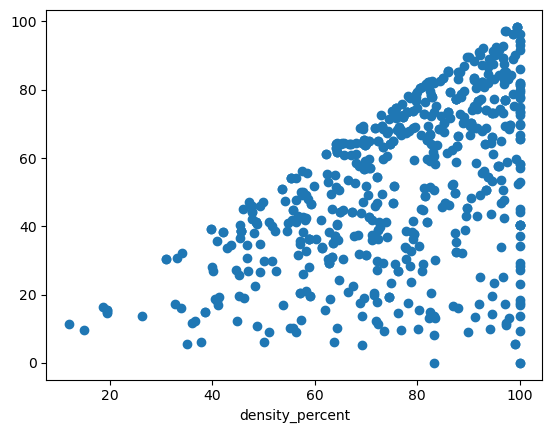

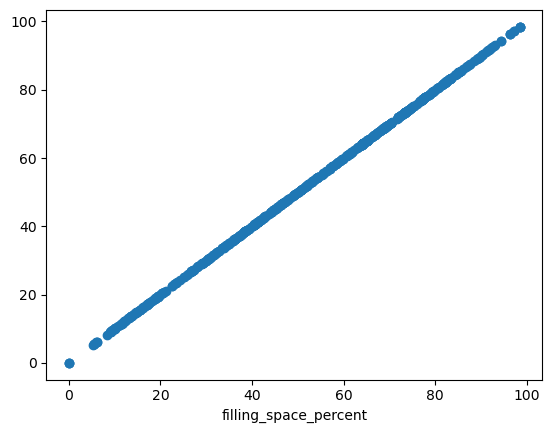

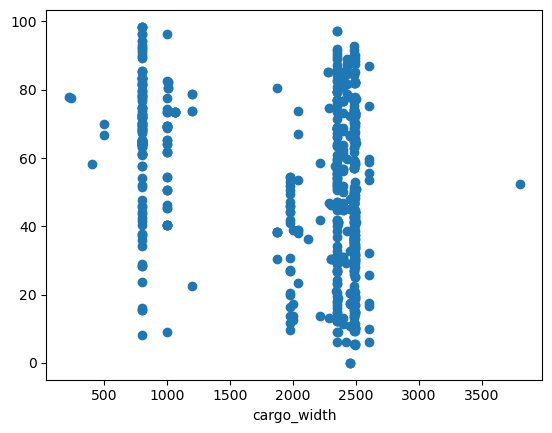

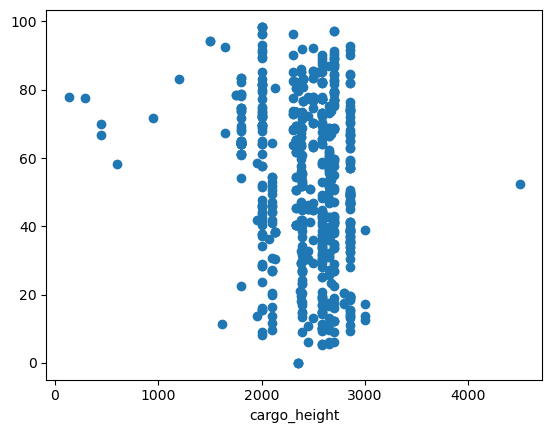

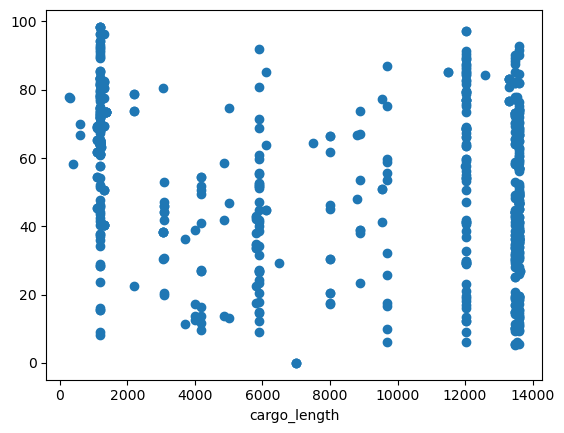

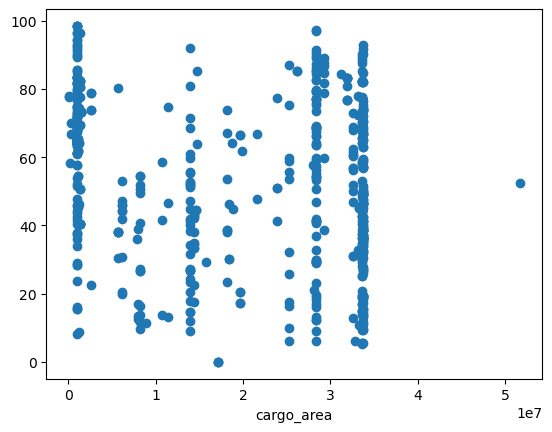

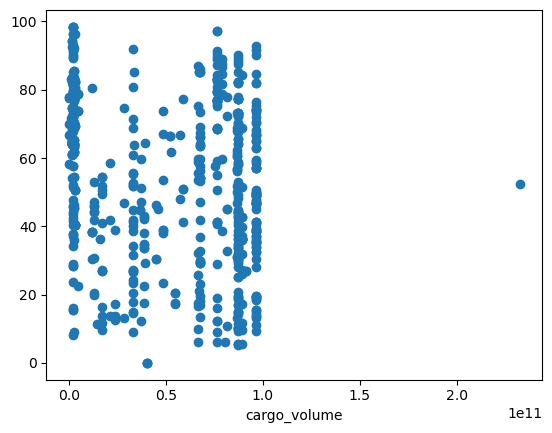

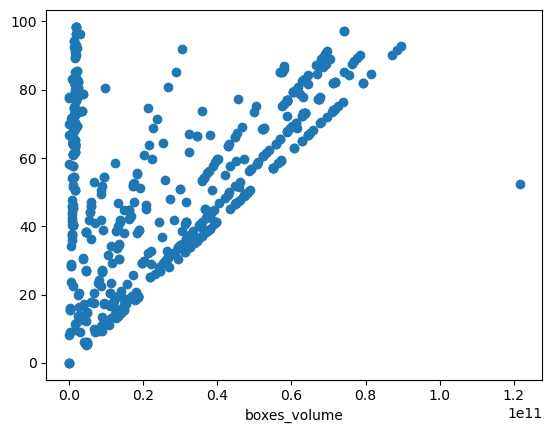

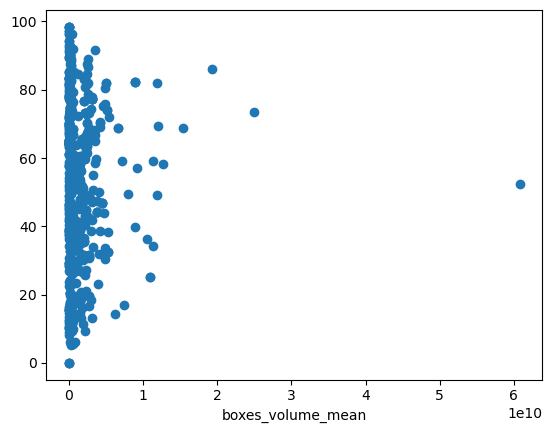

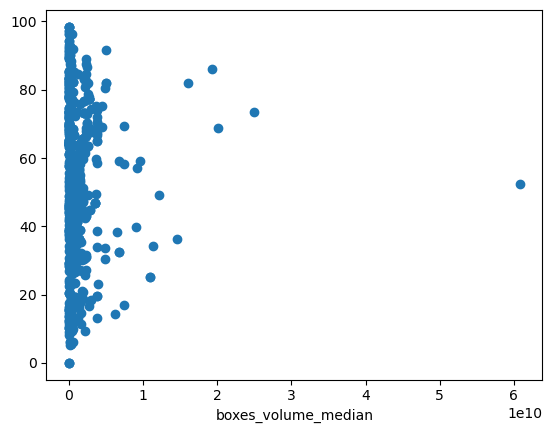

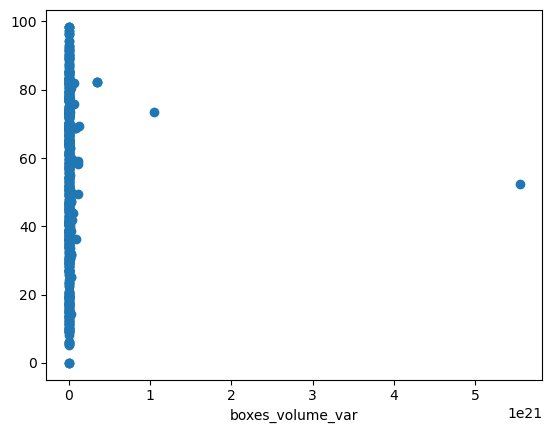

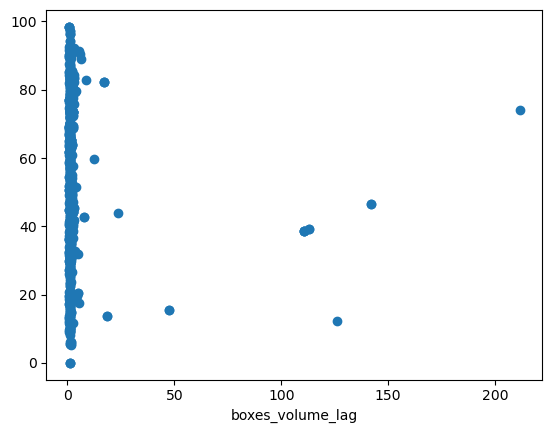

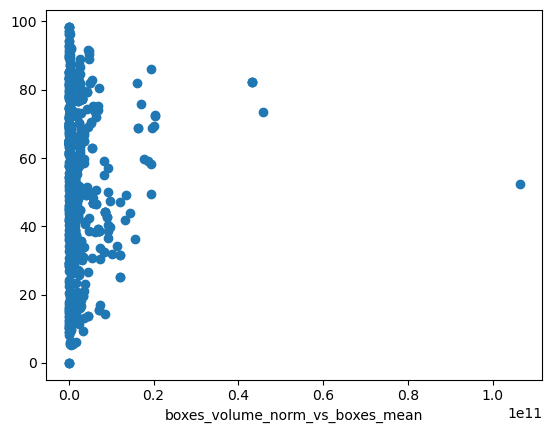

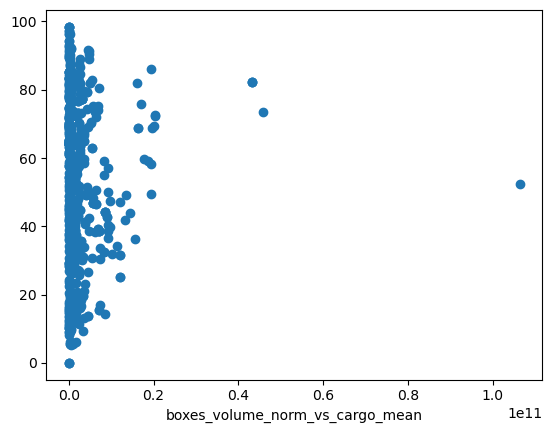

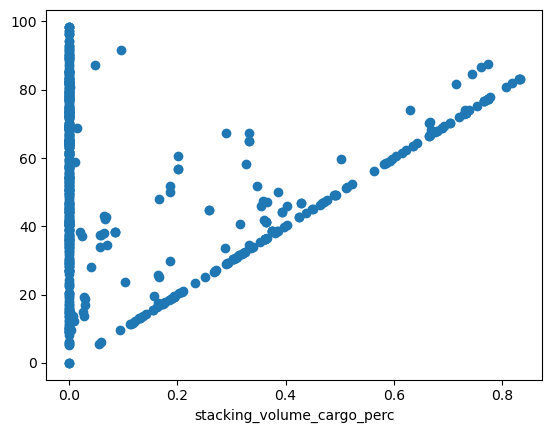

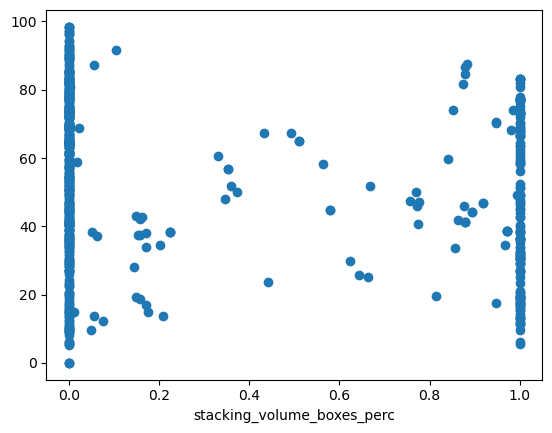

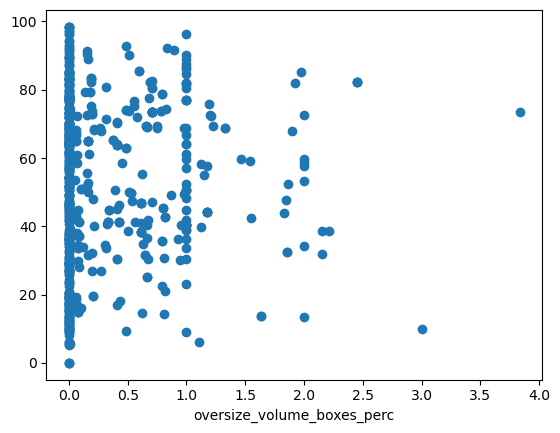

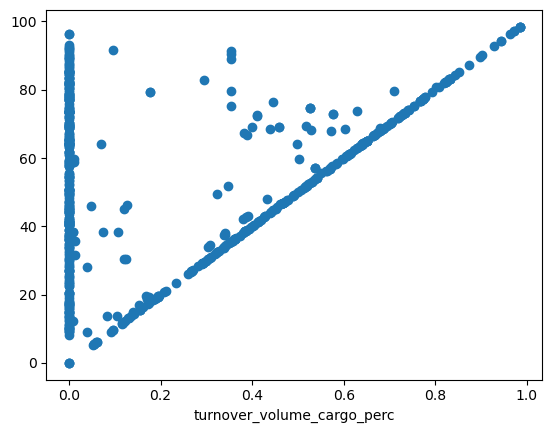

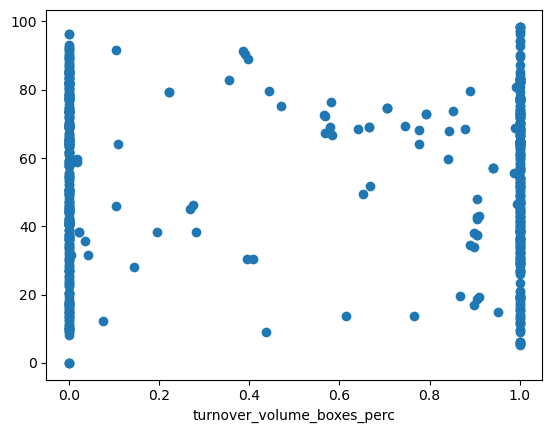

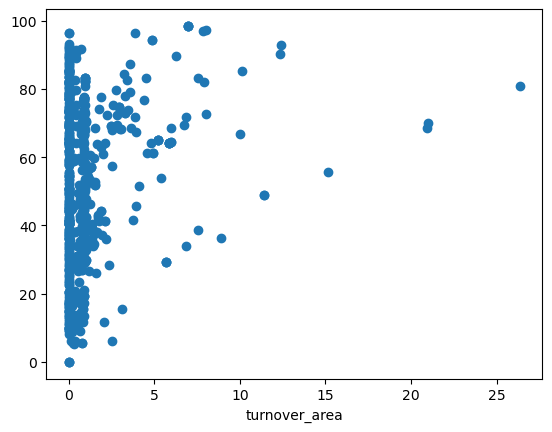

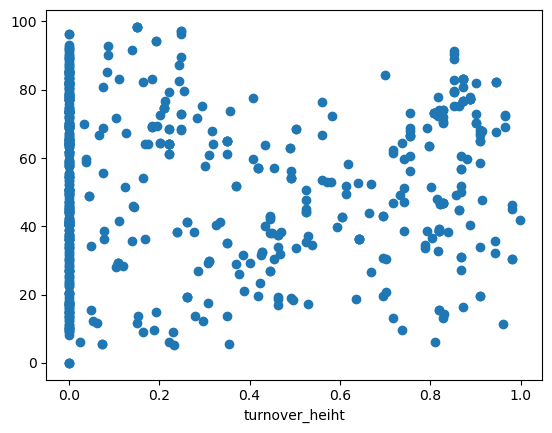

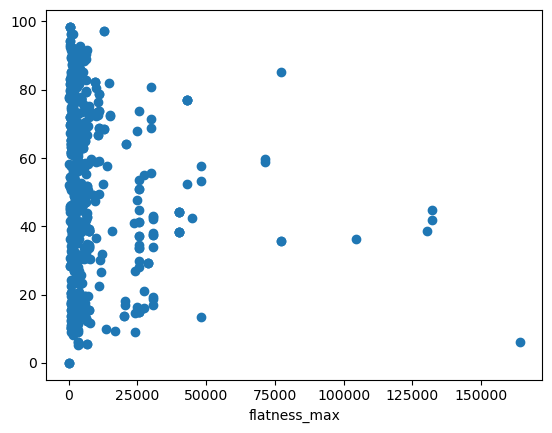

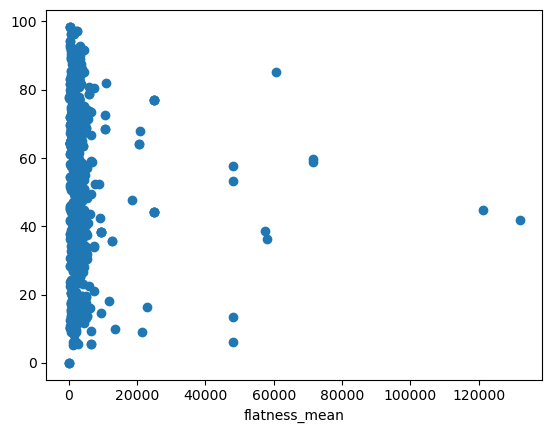

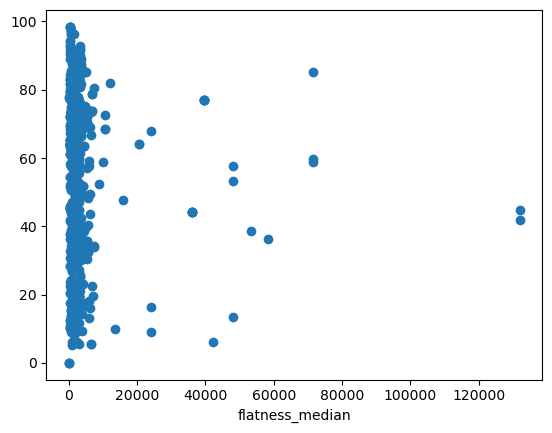

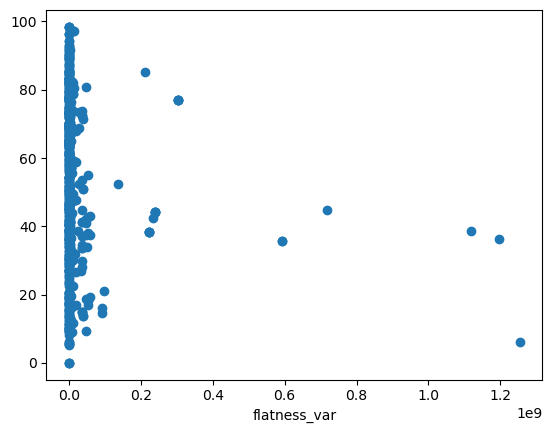

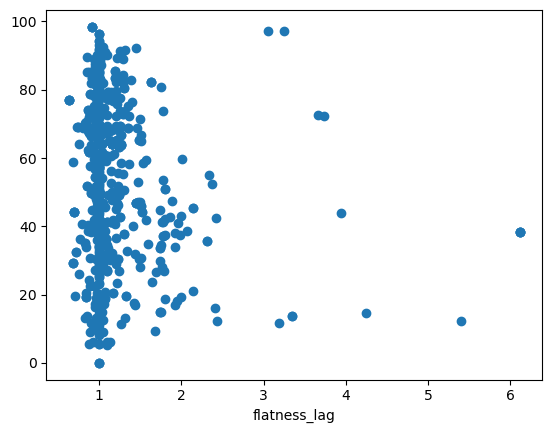

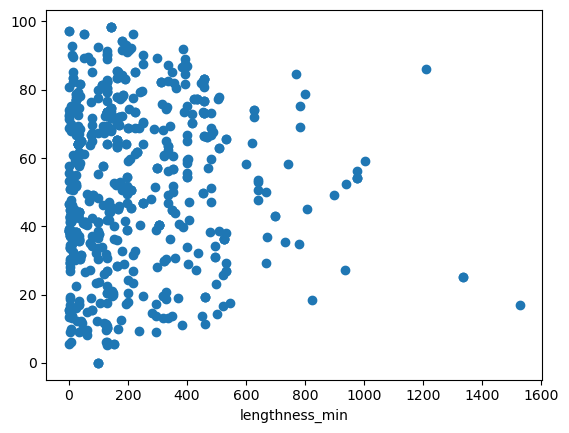

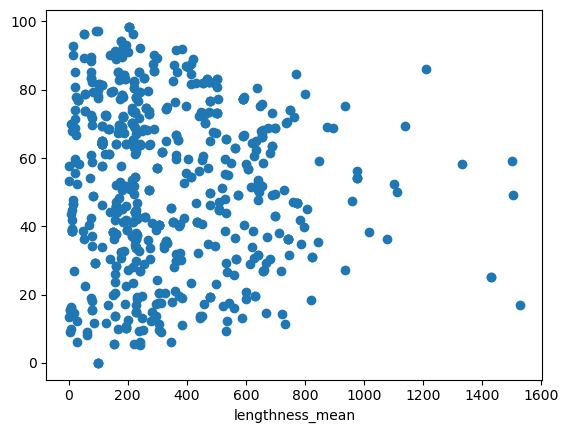

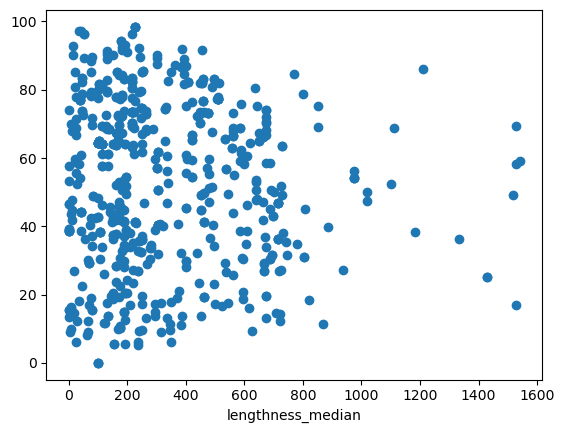

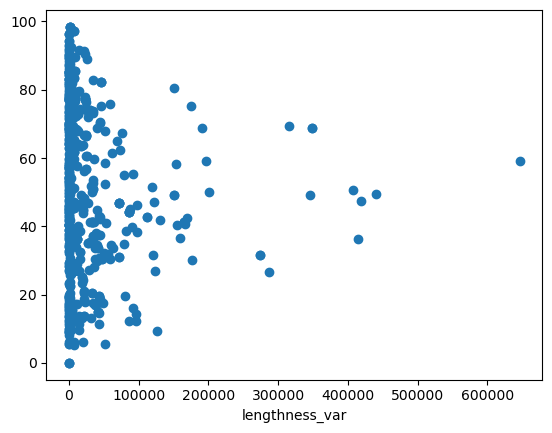

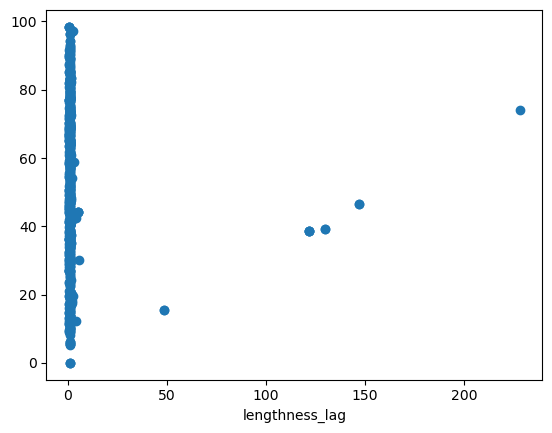

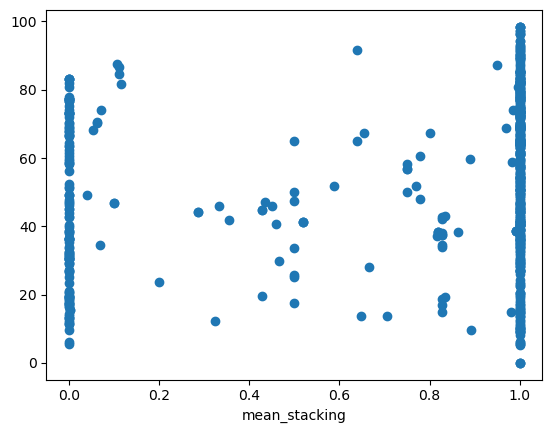

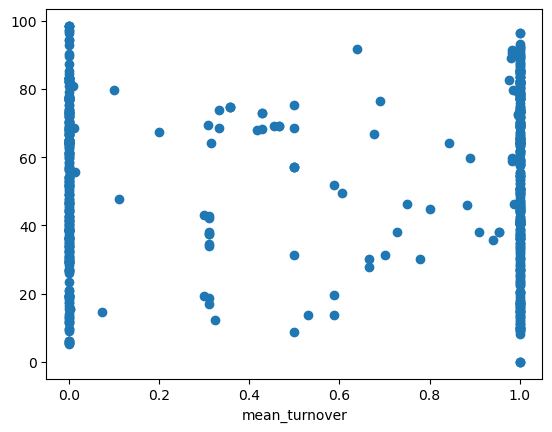

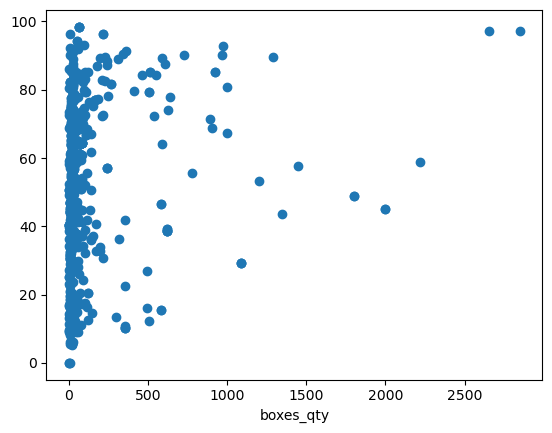

In [14]:
#Посмотрим зависимости
for column in ld:
    ddf=pd.DataFrame([])
    ddf[0]=ld[column]
    ddf[1]=ld['filling_space_percent']
    print(column)
    display(ddf.corr())
    fig, ax = plt.subplots()
    ax.scatter(ld[column],ld['filling_space_percent'])
    ax.set_xlabel(column)
    #plt.semilogx()